In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv


# **Importing Dataset**

In [66]:
df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv')
recipes = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv')
users = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv')

df_copy = df.copy(deep=True) #Copying the data to another dataframe
df = df.drop('date', axis=1) #Dropping timestamp
df.head()

,user_id,recipe_id,rating,u,i
0,2046,4684,5.0,22095,44367
1,2046,517,5.0,22095,87844
2,1773,7435,5.0,24732,138181
3,1773,278,4.0,24732,93054
4,2046,3431,5.0,22095,101723


# EDA - Exploratory Data Analysis
check for -

shape

datatype

missing values

finally get the summary and check

rating distribution.

number of users and products.

Users with highest no of ratings.

# Shape

In [67]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  698901
No of columns =  5


# Datatypes

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   rating     698901 non-null  float64
 3   u          698901 non-null  int64  
 4   i          698901 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 26.7 MB


# Missing value analysis

In [69]:
# Find number of missing values in each column
df.isna().sum()

user_id      0
recipe_id    0
rating       0
u            0
i            0
dtype: int64

# Summary

In [70]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    698901.000000
mean          4.574090
std           0.959022
min           0.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

# Rating distribution

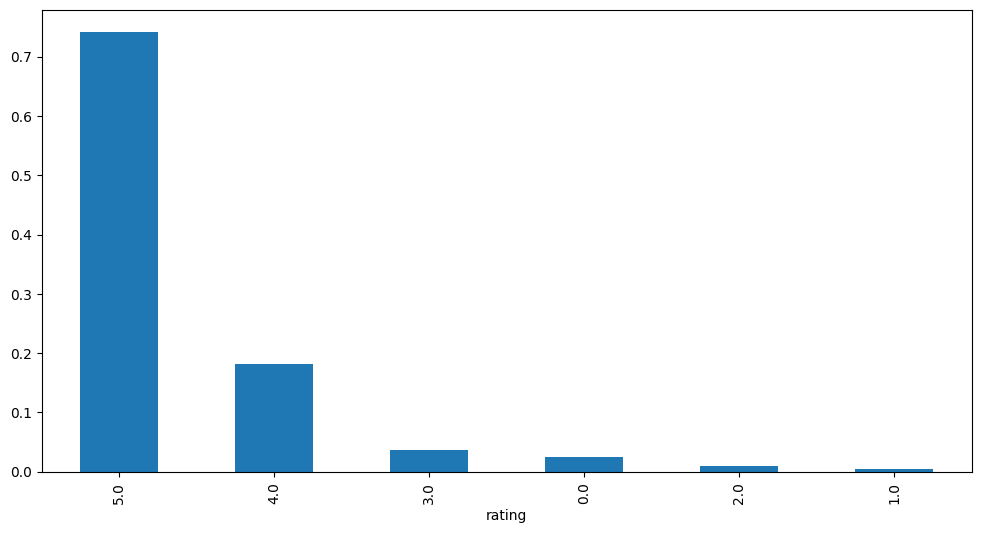

In [71]:
#Create the plot and provide observations
plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

# No of unique users and items

In [72]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique RECIPES in Raw data = ', df['recipe_id'].nunique())

Number of unique USERS in Raw data =  25076
Number of unique RECIPES in Raw data =  160901


# Users with most no of rating

In [73]:
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
424680    6437
37449     4581
383346    3656
169430    3465
128473    3338
89831     2851
199848    2798
133174    2733
58104     2602
226863    2457
dtype: int64

In [74]:
df['rating'].describe()

count    698901.000000
mean          4.574090
std           0.959022
min           0.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

# Pre-Processing
Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [75]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique RECIPES in the final data = ', df_final['recipe_id'].nunique())

The number of observations in the final data = 487799
Number of unique USERS in the final data =  2298
Number of unique RECIPES in the final data =  150817


The dataframe df_final has users who have rated 50 or more items
We will use df_final to build recommendation systems

# Checking the density of the rating matrix

In [76]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='recipe_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (2298, 150817)
given_num_of_ratings =  478907
possible_num_of_ratings =  346577466
density: 0.14%


recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
user_id,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [77]:
nan_values = df_final['rating'].isna().count()
# Fill NaN values in the 'rating' column with a specific value (e.g., 0)
df_final.describe()

,user_id,recipe_id,rating,u,i
count,4.877990e+05,487799.000000,487799.000000,487799.000000,487799.000000
mean,6.745411e+06,174977.608560,4.611221,1669.806039,87995.714731
std,1.113528e+08,131655.570052,0.865889,2088.670815,51313.697255
min,1.533000e+03,38.000000,0.000000,3.000000,2.000000
25%,8.983100e+04,64160.000000,4.000000,275.000000,43412.000000
50%,1.998480e+05,139836.000000,5.000000,816.000000,87839.000000
75%,4.037290e+05,266727.500000,5.000000,2256.000000,132304.000000
max,2.001362e+09,537458.000000,5.000000,16211.000000,178262.000000


In [78]:
# Calculate the average rating for each recipe 
average_rating = df_final.groupby('recipe_id').mean()['rating']

#Calculate the count of ratings for each recipe
count_rating = df_final.groupby('recipe_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
recipe_id,,
195722,5.0,1
240417,5.0,1
240603,5.0,1
240588,5.0,1
240585,5.0,1


In [79]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def rank_based_recommendation(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

# Recommending top n products with m minimum interactions based on popularity

In [80]:
list(rank_based_recommendation(final_rating, 5, 50))

[39900, 177017, 42976, 92072, 37374]

In [81]:
list(rank_based_recommendation(final_rating, 15, 100))

[27144,
 43509,
 66596,
 25723,
 74730,
 101104,
 116849,
 31128,
 69173,
 106627,
 29679,
 107997,
 2496,
 42169,
 21761]

# Collaborative Filtering based Recommendation System
# User based collaborative filtering

In [82]:
final_ratings_matrix.head()

recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
user_id,,,,,,,,,,,,,,,,,,,,,
1533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [83]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Function to find Similar users and their similarity scores

In [85]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

# Test the Similar_user function

In [86]:
similar = similar_users(3,final_ratings_matrix)[0][0:10] 
similar

[30, 2139, 978, 1253, 315, 1328, 796, 177, 1483, 1392]

In [87]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.03165028]]),
 array([[0.02771525]]),
 array([[0.02613386]]),
 array([[0.02598731]]),
 array([[0.02550831]]),
 array([[0.02545375]]),
 array([[0.02508823]]),
 array([[0.02455915]]),
 array([[0.02425141]]),
 array([[0.02409088]])]

In [88]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def user_based_recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

# Recommend x products to user index y based on similarity based collaborative filtering

In [89]:
user_based_recommendations(61,3,final_ratings_matrix)

[27136, 119810, 93699]

In [90]:

user_based_recommendations(112,20,final_ratings_matrix)

[106499,
 49172,
 40983,
 73754,
 90142,
 81951,
 221217,
 98345,
 24618,
 16432,
 49200,
 221240,
 106555,
 32833,
 98370,
 81989,
 57416,
 254025,
 32844,
 49230]

# Model based Collaborative Filtering: Singular Value Decomposition
**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use k=50 latent features to predict rating of products

# CSR matrix

In [91]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

# SVD

In [92]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

# Predicting ratings

In [93]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

# Function to recommend products

In [94]:
def model_based_recommendations(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))

# Recommending recipes

In [95]:
#Enter 'user index' and 'num_recommendations' for the user
model_based_recommendations(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
9649     0.402373
7737     0.327952
60355    0.294952
14739    0.294071
9263     0.285404
Name: user_predictions, dtype: float64


# Evaluating the model

In [96]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

recipe_id
38    0.001741
40    0.006092
45    0.002176
46    0.002176
49    0.008268
dtype: float64

In [98]:
preds_df.head()

recipe_id,38,40,45,46,49,52,58,59,62,63,...,536401,536411,536643,536679,536726,536729,536990,537175,537319,537458
0,0.000284,0.002274,0.000123,0.002192,0.004619,0.000054,0.021549,0.000045,0.003700,0.000486,...,0.000001,0.002073,0.000356,0.001557,0.001557,0.005149,0.002230,0.003409,0.000010,0.001508
1,0.003288,0.010907,0.005798,0.018466,0.052872,0.013520,0.017297,0.001776,0.037209,0.001279,...,0.001365,0.031815,0.004109,0.004002,0.004002,0.011647,0.031600,0.009429,0.000281,0.010740
2,0.000764,0.004955,0.000922,0.003422,0.043636,0.021624,0.015523,0.000630,0.013609,0.001500,...,0.001134,0.005073,0.000955,0.000925,0.000925,0.000657,0.002415,0.017110,0.000267,0.005837
3,0.000481,0.002298,0.000494,0.000942,0.012728,0.005509,0.016604,0.000307,0.005419,0.000732,...,0.000387,0.000493,0.000602,0.006044,0.006044,0.008671,0.003956,0.000170,0.000246,0.000537
4,0.000225,0.001014,0.000267,0.001030,0.001913,0.000450,0.000409,0.000115,0.002548,0.000255,...,0.000164,0.001125,0.000282,0.001534,0.001534,0.004629,0.001871,0.001435,0.000024,0.001669


In [99]:
avg_preds=preds_df.mean()
avg_preds.head()

recipe_id
38    0.001390
40    0.003277
45    0.002074
46    0.004465
49    0.018694
dtype: float64

In [100]:

rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
recipe_id,,
38,0.001741,0.001390
40,0.006092,0.003277
45,0.002176,0.002074
46,0.002176,0.004465
49,0.008268,0.018694


In [101]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.005797463350263102 

